In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set_style("whitegrid")
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from pmdarima.arima import ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose

from statsforecast import StatsForecast
from statsforecast.models import seasonal_naive, auto_arima
from statsforecast.utils import AirPassengers

import warnings
warnings.filterwarnings('ignore')
GLOBAL_BLUE = "#4285F4"
GLOBAL_RED = "#DB4437"
GLOBAL_YELLOW = "#F4B400"
GLOBAL_GREEN = "#0F9D58"

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
def test_stationarity(col):
    testresult = ADFTest(alpha=0.05).should_diff(col)
    p, text = testresult[0], testresult[1]
    print('p-value: ' + str(round(p,2)))
    print('Ar reikia diferencijuoti: ' + str(text))
    
def split_dataset(col):
    train = col[col.index <= "2022-02-13"].XRP_price
    test = col[col.index > "2022-02-13"].XRP_price
    print(col.shape, train.shape, test.shape)
    
    return train, test

def plot_decomposition(col, period, timeframe):
    ts_dicomposition = seasonal_decompose(col, model='additive', period=period)
    trend_estimate = ts_dicomposition.trend
    seasonal_estimate = ts_dicomposition.seasonal
    residual_estimate = ts_dicomposition.resid

    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    # First plot to the Original time series
    axes[0].plot(col.XRP_price, label='Original', color = GLOBAL_BLUE, linewidth = 3) 
    axes[0].legend(loc='upper left');
    # second plot to be for trend
    axes[1].plot(trend_estimate, label='Trend', color = GLOBAL_RED, linewidth = 3)
    axes[1].legend(loc='upper left');
    # third plot to be Seasonality component
    axes[2].plot(seasonal_estimate, label='Seasonality', color = GLOBAL_YELLOW, linewidth = 3)
    axes[2].legend(loc='upper left');
    # last last plot to be Residual component
    axes[3].plot(residual_estimate, label='Residuals', color = GLOBAL_GREEN, linewidth = 3)
    axes[3].legend(loc='upper left');
    plt.savefig('images/' + timeframe + '_decomposition.pdf', format = "pdf", dpi = 300)
    return trend_estimate, seasonal_estimate, residual_estimate

def plotpredict(model, test):
    forecasts = model.predict(test.shape[0])
    x = np.arange(test.shape[0])
    plt.plot(x, test, c='blue', label = "true")
    plt.plot(x, forecasts, c='green', label = "prediction")
    plt.legend(loc="upper left")
    plt.show()
    
def model_ar(train, valid):
    print("AR:")
    ar = auto_arima(
        train,
        start_p=1, max_p=30,
        start_q=0, max_q=0, 
        d=0,
        seasonal=True,
        trace=False,
        stepwise=True)
    
    plotpredict(ar, valid)

def model_arma(train, valid):
    print("ARMA:")
    arma = auto_arima(
        train,
        start_p=1, max_p=30,
        start_q=1, max_q=30,
        d=0,           
        seasonal=True,  
        trace=False,
        stepwise=True)
    
    plotpredict(arma, valid)
        
def model_arima(train, valid):
    print("ARIMA:")
    arima = auto_arima(
        train, 
        start_p=1, max_p=30,
        start_q=1, max_q=30,
        d=None,
        seasonal=True,
        trace=False,
        stepwise=True)
    
    plotpredict(arima,valid)
    
def plot_and_save_residuals(residuals, timeframe ):
    plt.figure(figsize=(7, 5))
    ax = sns.distplot(residuals, bins = 30)
    ax.set(xlabel='Residual', ylabel='Count')
    plt.axvline(residuals.mean(), c='k', ls='-', lw=2.5)
    plt.axvline(residuals.median(), c='orange', ls='--', lw=2.5)
    plt.savefig('images/' + timeframe + '_residuals_distribution.pdf', format = "pdf", dpi = 300)
    plt.show()

def test_normality(data):
    test, p = shapiro(data)
    print("P value: ", p)
    
def plotanddoarima(test, train, tf, freq, timeframename):
    horizon = len(test)
    series_train = pd.DataFrame(
        {
            'ds': train.index,
            'y': train.values
        },
        index=pd.Index([0] * train.size, name='unique_id')
    )

    fcst = StatsForecast(
        series_train, 
        models=[(auto_arima, tf)], 
        freq=freq, 
        n_jobs=1
    )

    forecasts = fcst.forecast(horizon)

    forecasts['y_test'] = test.values

    fig, ax = plt.subplots(1, 1, figsize = (20, 7))
    df_plot = pd.concat([series_train, forecasts]).set_index('ds')
    df_plot[['y', 'y_test', 'auto_arima_season_length-'+str(tf)]].plot(ax=ax, linewidth=2)
    ax.set_title('AirPassengers Forecast', fontsize=22)
    ax.set_ylabel('Monthly Passengers', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()
    
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)
    
    plt.savefig('images/' + timeframename + '_arima_results.pdf', format = "pdf", dpi = 300)
    plt.show()
    
    toc = df_plot.reset_index(drop = True).iloc[:, 1:].dropna()
    pred = toc.iloc[:, 0]
    real = toc.iloc[:, 1]
    print("MAPE:", 100*sum(abs((real - pred)/real))/len(pred))


# Day

In [9]:
day = pd.read_csv("data/full_day.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
day_train, day_test = split_dataset(day)
test_stationarity(day.XRP_price)

(55, 1) (38,) (17,)
p-value: 0.39
Ar reikia diferencijuoti: True


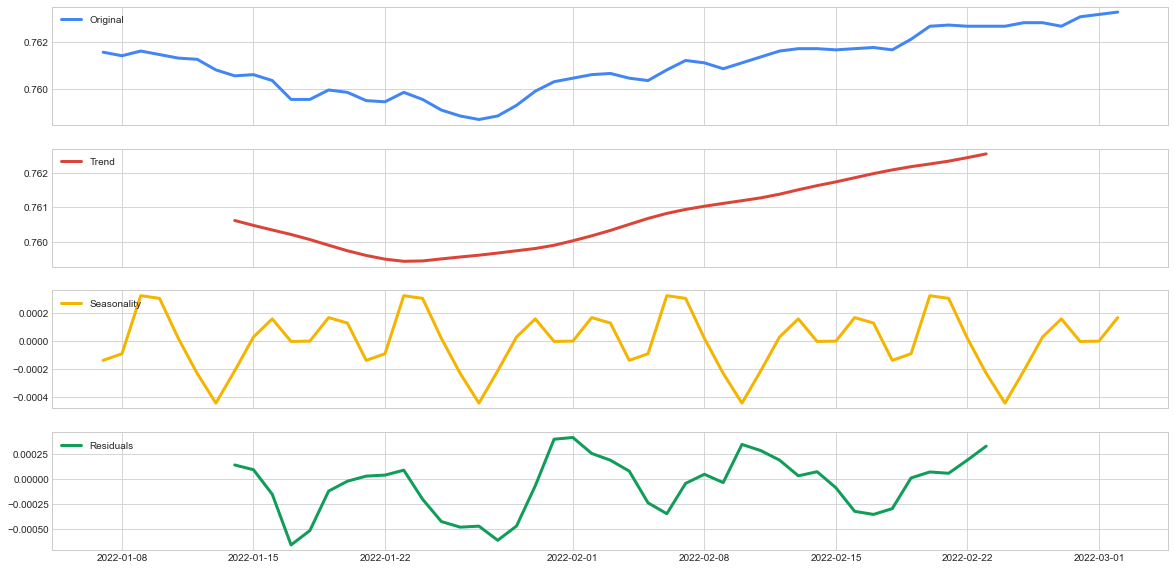

In [10]:
day_trend, day_seasonal, day_residuals = plot_decomposition(day, 14, "day")

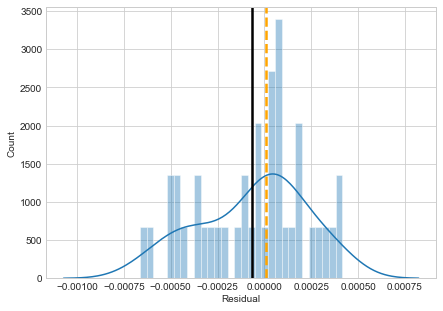

P value:  1.0


In [11]:
plot_and_save_residuals(day_residuals, "day")
test_normality(day_residuals)

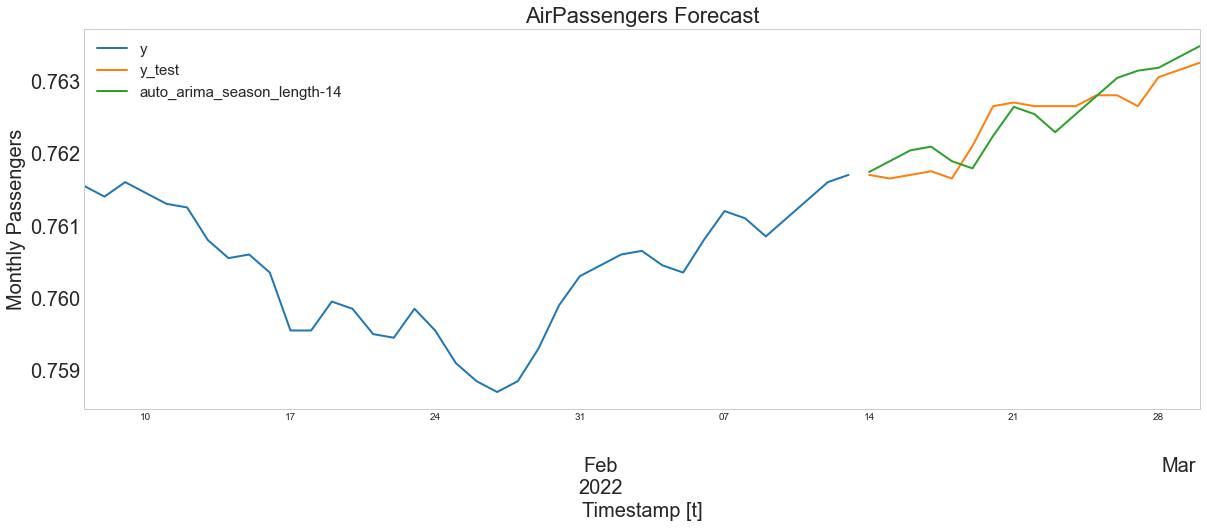

MAPE: 0.02962697003828522


In [12]:
plotanddoarima(day_test, day_train,14, '1D', "day")

# Hour

In [13]:
hour = pd.read_csv("data/full_hour.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
hour_train, hour_test = split_dataset(hour)
test_stationarity(hour.XRP_price)

(1271, 1) (888,) (383,)
p-value: 0.76
Ar reikia diferencijuoti: True


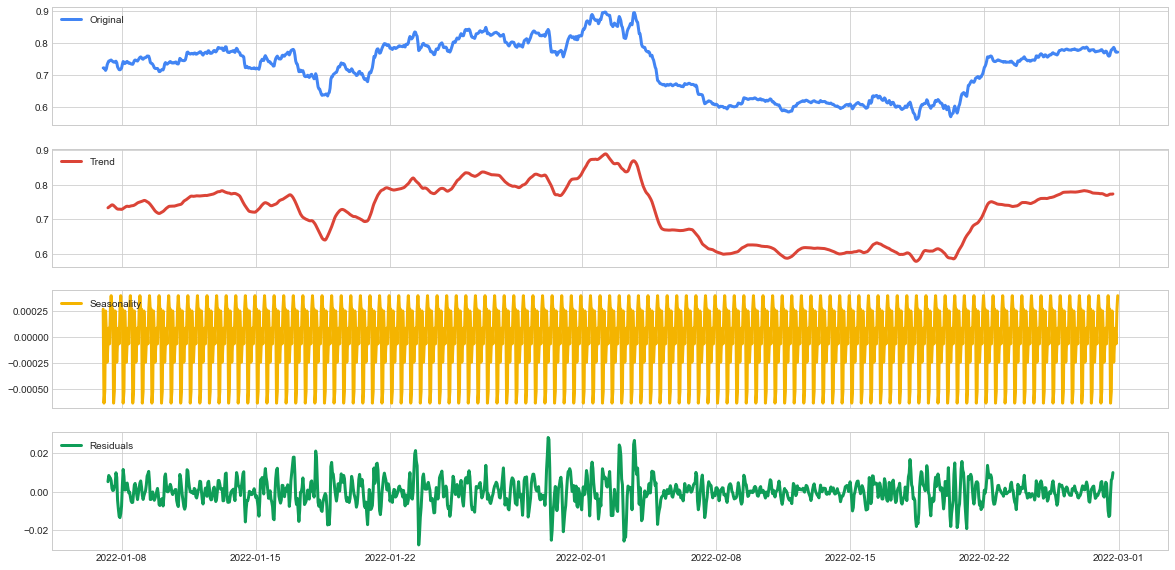

In [14]:
hour_trend, hour_seasonal, hour_residuals = plot_decomposition(hour, 12, "hour")

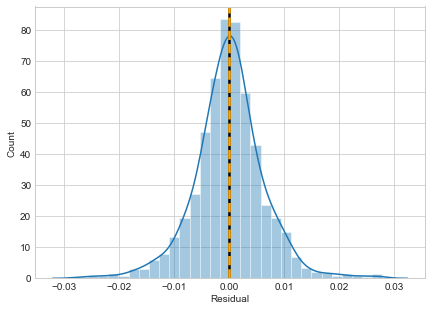

P value:  1.0


In [15]:
plot_and_save_residuals(hour_residuals, "hour")
test_normality(hour_residuals)

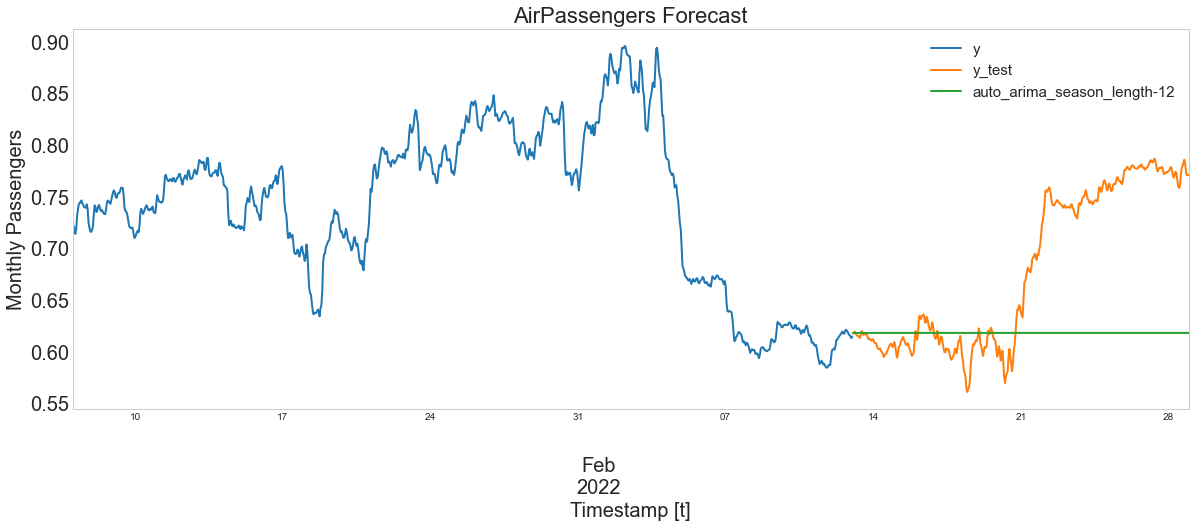

MAPE: 9.992968876819601


In [16]:
plotanddoarima(hour_test, hour_train, 12, '1H', "hour")

# Minute

In [17]:
minute = pd.read_csv("data/full_minute.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
minute_train, minute_test = split_dataset(minute)
test_stationarity(minute.XRP_price)

(76312, 1) (53280,) (23032,)
p-value: 0.75
Ar reikia diferencijuoti: True


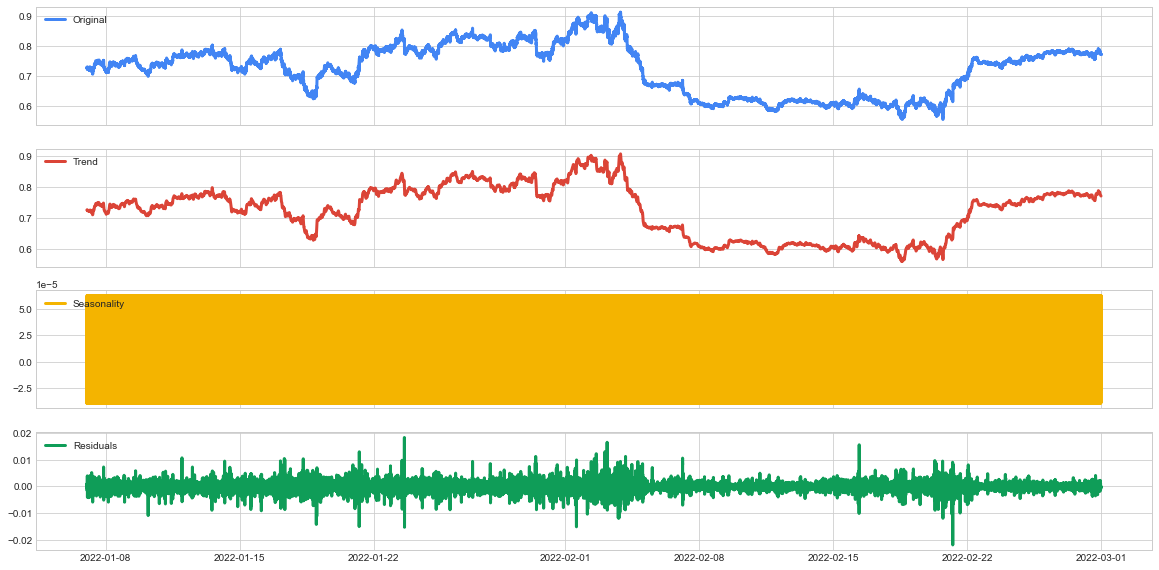

In [18]:
minute_trend, minute_seasonal, minute_residuals =  plot_decomposition(minute, 30, "minute")

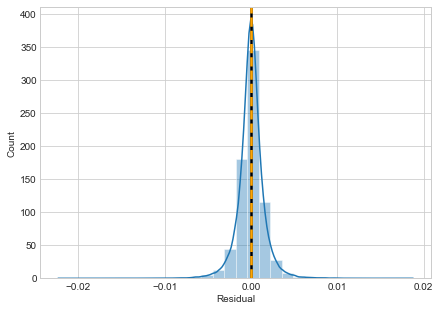

P value:  1.0


In [19]:
plot_and_save_residuals(minute_residuals, "minute")
test_normality(minute_residuals)

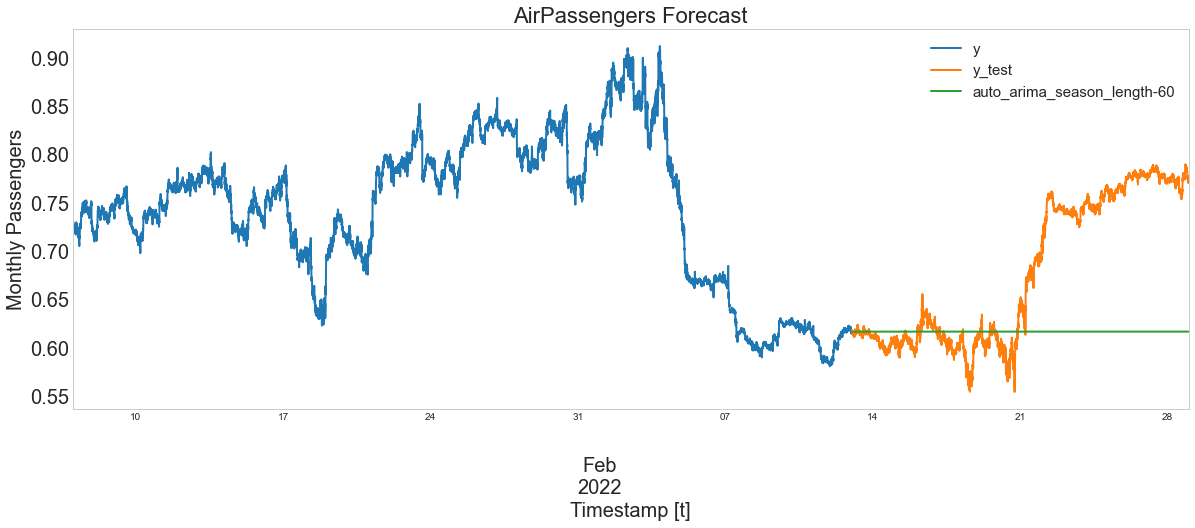

MAPE: 9.855727230782984


In [20]:
plotanddoarima(minute_test, minute_train, 60, '1MIN', "minute")

### Conclusions

1. All time series are not stationary
2. Autoregressive models are not a good fit for ripple price